In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

### Extracting features from accelerations
Profiles/accelerations are made with generateiriforml.py.  
There are 1150 profiles, and parameters are all combinations of:
1. profile_types = ['A', 'B', 'C']  
2. velocities = np.linspace(5, 35, 11)  
3. deltas = np.linspace(0.1, 0.5, 5)  (dx)
4. sample_rates = [np.linspace(50, 200, 7)]  
Additionally, there's 5 from each.

In [2]:
"""
filenames = os.listdir("data_for_iri_ml/")
df = pd.DataFrame()

for f in filenames:
    profile = pd.read_csv("data_for_iri_ml/"+ str(f))
    minimum = np.min(profile['Sprung_Mass_Acc'])
    maximum = np.max(profile['Sprung_Mass_Acc'])
    average = np.average(profile['Sprung_Mass_Acc'])
    variance = np.var(profile['Sprung_Mass_Acc'])
    df = df.append({'id': f[:-4], 'min': minimum, 'max': maximum, 
               'range': maximum-minimum, 'var': variance, 'mean': average, 
                'iri': profile['IRI'][0], 'vel': profile['Velocity(m/s)'][0],
                'dx': profile['DX'][0]}, ignore_index = True)

df.to_csv("data/predict_iri_data2.csv", index = False)
"""

'\nfilenames = os.listdir("data_for_iri_ml/")\ndf = pd.DataFrame()\n\nfor f in filenames:\n    profile = pd.read_csv("data_for_iri_ml/"+ str(f))\n    minimum = np.min(profile[\'Sprung_Mass_Acc\'])\n    maximum = np.max(profile[\'Sprung_Mass_Acc\'])\n    average = np.average(profile[\'Sprung_Mass_Acc\'])\n    variance = np.var(profile[\'Sprung_Mass_Acc\'])\n    df = df.append({\'id\': f[:-4], \'min\': minimum, \'max\': maximum, \n               \'range\': maximum-minimum, \'var\': variance, \'mean\': average, \n                \'iri\': profile[\'IRI\'][0], \'vel\': profile[\'Velocity(m/s)\'][0],\n                \'dx\': profile[\'DX\'][0]}, ignore_index = True)\n\ndf.to_csv("data/predict_iri_data2.csv", index = False)\n'

### First look at the data I created
It looks pretty compliated

In [3]:
df = pd.read_csv("data/predict_iri_data2.csv")

In [4]:
df.head()

,dx,id,iri,max,mean,min,range,var,vel
0,0.642308,B_4_32.0_0.30000000000000004_50.csv,4.013196,2.150981,-0.012472,-1.934487,4.085468,0.437296,32.0
1,0.208333,C_8_26.0_0.4_125.csv,8.702281,3.329420,0.025419,-4.254629,7.584049,1.684266,26.0
2,0.066667,C_6_5.0_0.2_75.csv,8.089321,1.065013,0.000201,-1.160010,2.225023,0.102811,5.0
3,0.040000,B_4_8.0_0.2_200.csv,4.250913,1.081296,-0.001118,-1.236504,2.317800,0.084378,8.0
4,0.040000,B_2_5.0_0.1_125.csv,3.987772,4.196655,0.000787,-2.516152,6.712807,0.068249,5.0


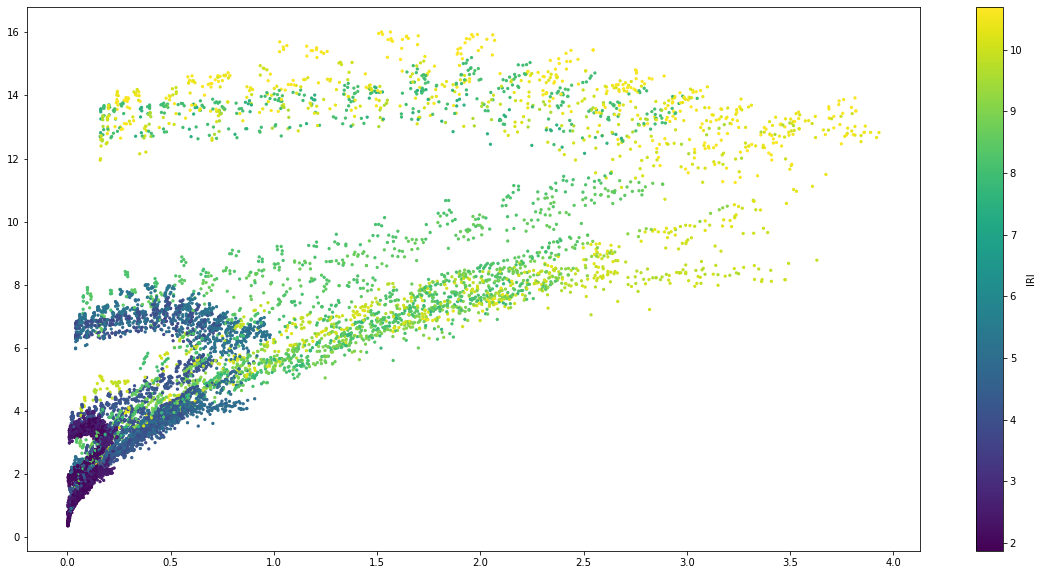

In [5]:
plt.figure(figsize = (20, 10))
plt.scatter(df['var'], df['range'], s = 5, c = df['iri'])
cb = plt.colorbar()
cb.set_label('IRI')

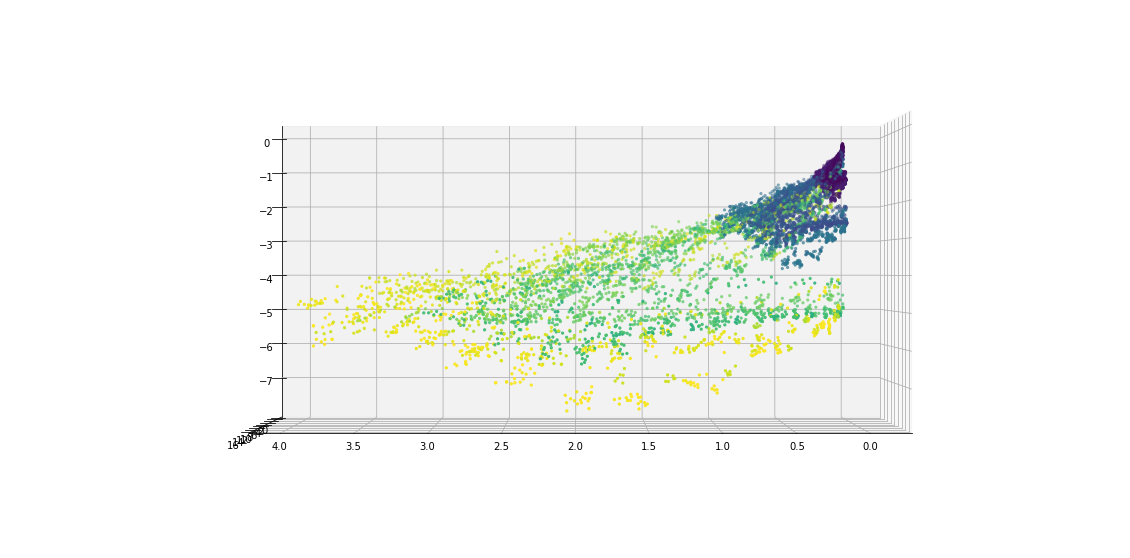

In [7]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['var'], df['range'], df['min'], c = df['iri'], s = 5)
ax.view_init(0, 90)

#### But thankfully velocities seem to separate the data nicely
So let's look at 1 velocity at the time

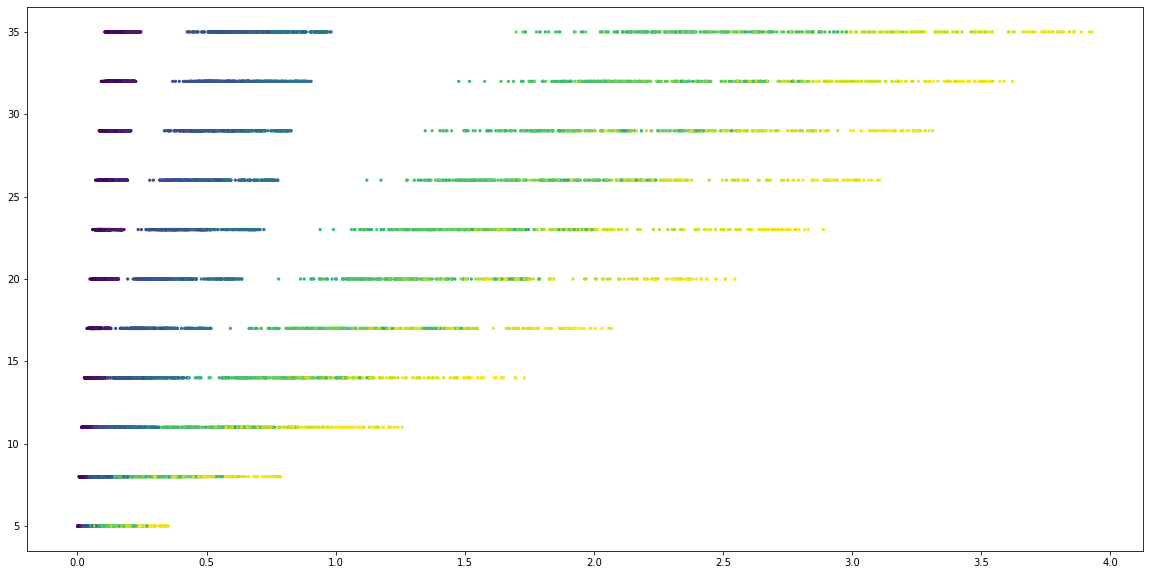

In [8]:
fig = plt.figure(figsize = (20, 10))
plt.scatter(df['var'], df['vel'], c = df['iri'], s = 5)
plt.show()

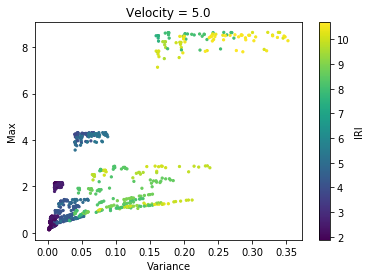

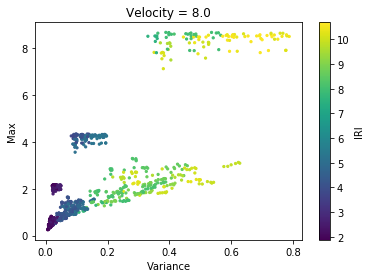

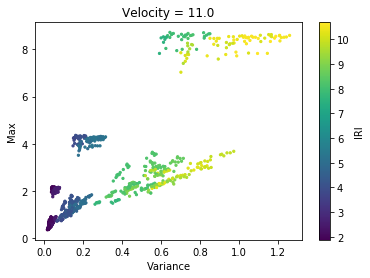

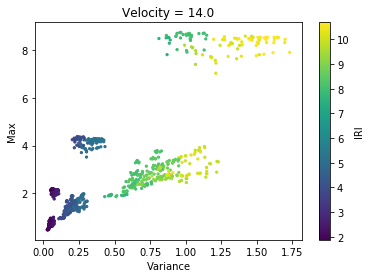

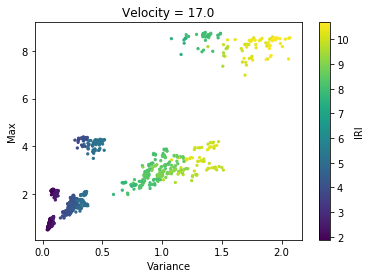

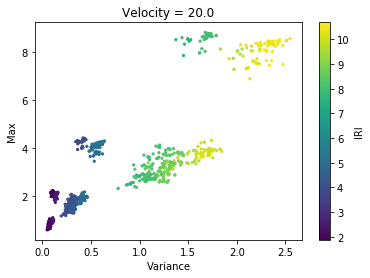

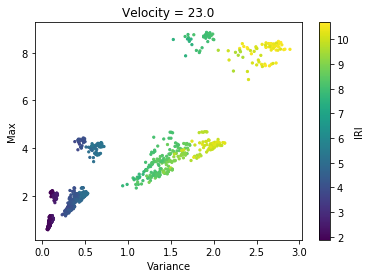

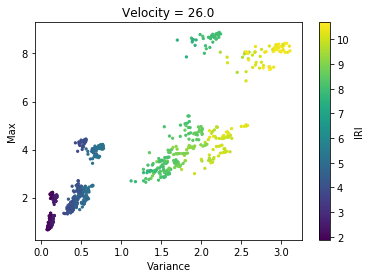

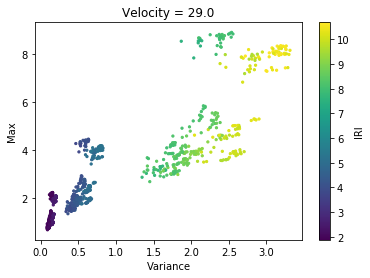

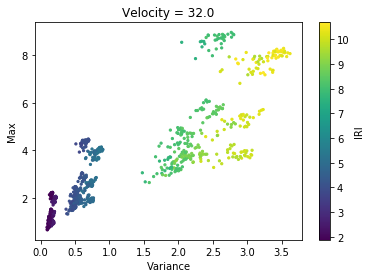

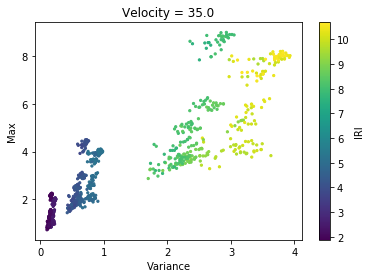

In [9]:
velocities = np.linspace(5, 35, 11) 
for v in velocities:
    vel = df.loc[df['vel'] == v]
    plt.scatter(vel['var'], vel['max'], s = 5, c = vel['iri'])
    plt.xlabel('Variance')
    plt.ylabel('Max') 
    plt.title("Velocity = " + str(v))
    cb = plt.colorbar()
    cb.set_label('IRI')
    plt.show()

1. I think those gaps come from the type of the roads and maybe a bit because of sampling rate and dx
2. The lower the velocity, that weirder the plot. For now, let's just experiment with a normal 80-90km/h, so for example the df where velocity is 23

In [63]:
vel = df.loc[df['vel'] == 23]
X = np.concatenate((vel['var'].values[:, np.newaxis], vel['max'].values[:, np.newaxis]), axis = 1)
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

1. We fit a sqrt(x) line on the data. (cause it looks like a good fit) Variance is x, max is target
2. We pick n neighbour from the fitted line. eg. 100 within this range
3. We assign each datapoint to the neighbors

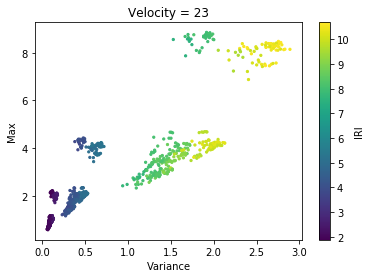

In [12]:
plt.scatter(vel['var'], vel['max'], s = 5, c = vel['iri'])
plt.xlabel('Variance')
plt.ylabel('Max') 
plt.title("Velocity = 23")
cb = plt.colorbar()
cb.set_label('IRI')

In [72]:
X = vel['var']
y = vel['max']
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]
    
poly_features = PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train)
print(X_train_poly.shape)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)


line_x = np.linspace(0, 3, 100)[:, np.newaxis]
line_y = poly_model.predict(poly_features.fit_transform(line_x))


(787, 3)


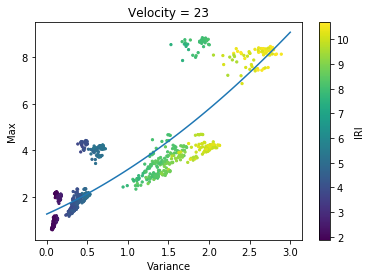

In [73]:
plt.scatter(vel['var'], vel['max'], s = 5, c = vel['iri'])
plt.xlabel('Variance')
plt.ylabel('Max') 
plt.title("Velocity = 23")
cb = plt.colorbar()
cb.set_label('IRI')

plt.plot(line_x, line_y)

In [58]:
def square_root_features(X):
    new = np.hstack((np.ones_like(X), X, np.sqrt(X)))
    return new

In [64]:

X_train = X[:, 0][:, np.newaxis]
y_train = X[:, 1][:, np.newaxis]


X_train_root = square_root_features(X_train)

poly_model = LinearRegression()
poly_model.fit(X_train_root, y_train)


line_x_2 = np.linspace(0, 4, 100)[:, np.newaxis]
line_y_2 = poly_model.predict(square_root_features(line_x))

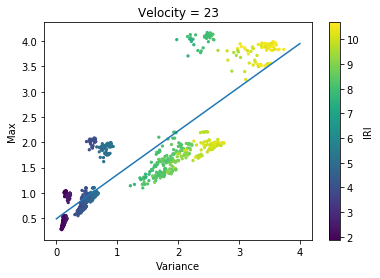

In [67]:
plt.scatter(X[:, 0], X[:, 1], s = 5, c = vel['iri'])
plt.xlabel('Variance')
plt.ylabel('Max') 
plt.title("Velocity = 23")
cb = plt.colorbar()
cb.set_label('IRI')
plt.plot(line_x_2, line_y_2)